# ML

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cargamos las librerías necesarias
import math
from functools import reduce

import pandas as pd
import numpy as np
from pygam import GAM, te, f, s, te
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
import shap

from src.visualization.metrics_summary import cross_val_reg, gam_cross_val_reg, err_hist, pred_hist, plot_residuo, plot_corr_matrix

/home/vacek/anaconda3/envs/descansare/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/vacek/anaconda3/envs/descansare/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Leemos los datos
perfiles_sqr = pd.read_parquet('../data/processed/perfiles_sqr_knn.parquet')

# Lateral = 0, Supine = 1
# Male = 1, Female = 0

## Recodificar presiones 

In [4]:
pd.set_option('display.max_rows', None)
presiones_count = perfiles_sqr.groupby('presiones').count().sort_values(by='sexo', ascending=False).drop(columns = ['sexo','posicion', 'altura', 'peso'])
presiones_count.rename(columns = {'sqr': 'count'}, inplace = True)

In [5]:
presiones_usuales = presiones_count[presiones_count['count'] > 100].index.values
presiones_recodificadas = [i if i in presiones_usuales else 'NA' for i in perfiles_sqr.presiones]

In [6]:
le = preprocessing.LabelEncoder()
perfiles_sqr['presiones'] = le.fit_transform(presiones_recodificadas)

## Dataset 

In [7]:
X = perfiles_sqr[['posicion', 'sexo', 'presiones', 'altura', 'peso']]
y = perfiles_sqr['sqr']

## Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

## Random Forest

In [9]:
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rfr.fit(train_X, train_y)

RandomForestRegressor(max_features='sqrt', n_estimators=300, n_jobs=-1,
                      random_state=42)

## Feature importance

In [10]:
perm = PermutationImportance(rfr, random_state=42, n_iter=10).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.3404 ± 0.0181,peso
0.3293 ± 0.0160,altura
0.2567 ± 0.0208,presiones
0.1077 ± 0.0163,posicion
0.0682 ± 0.0094,sexo


## Shap value

In [11]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfr)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

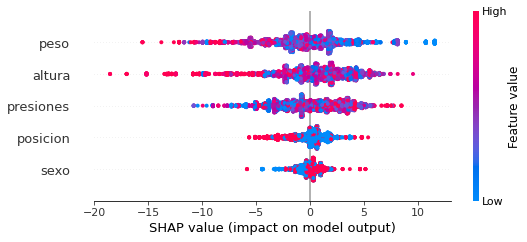

In [12]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, val_X)

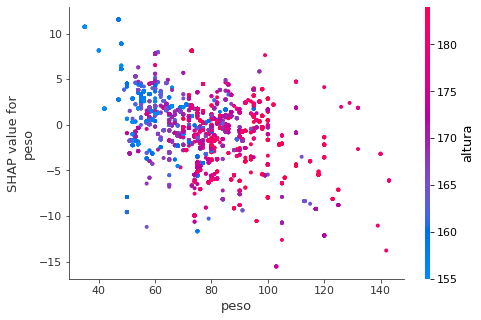

In [13]:
# make plot.
shap.dependence_plot('peso', shap_values, val_X, interaction_index="altura")


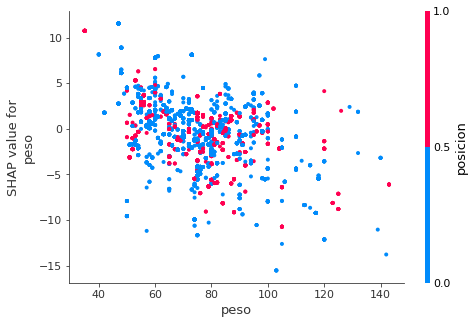

In [14]:
# make plot.
shap.dependence_plot('peso', shap_values, val_X, interaction_index="posicion")


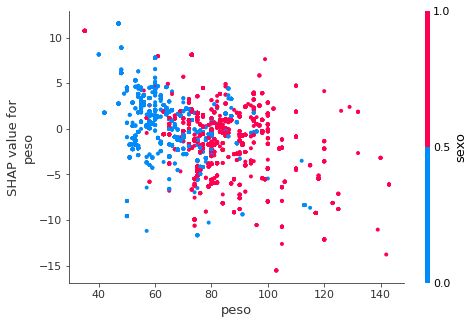

In [15]:
# make plot.
shap.dependence_plot('peso', shap_values, val_X, interaction_index="sexo")


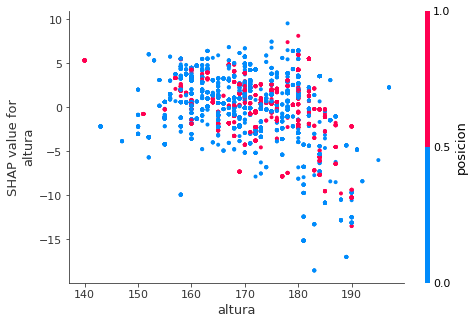

In [16]:
# make plot.
shap.dependence_plot('altura', shap_values, val_X, interaction_index="posicion")


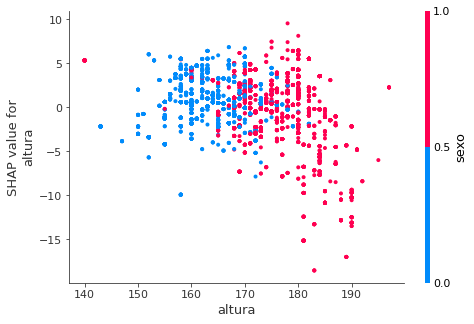

In [17]:
# make plot.
shap.dependence_plot('altura', shap_values, val_X, interaction_index="sexo")


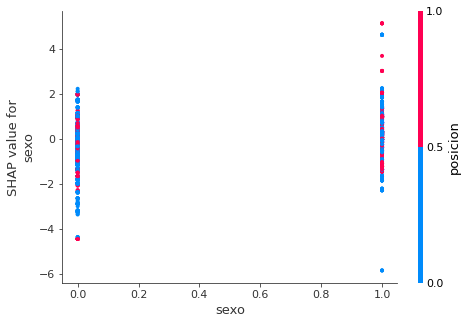

In [18]:
# make plot.
shap.dependence_plot('sexo', shap_values, val_X, interaction_index="posicion")


## Cross-validation

In [19]:
rfr_test = RandomForestRegressor(**params)

Metrics summary: 
╒═══════════════╤═══════╤════════╤════════════╤════════╤═══════════╕
│               │    Nº │   rmse │   rmse_std │    mae │   mae_std │
╞═══════════════╪═══════╪════════╪════════════╪════════╪═══════════╡
│ Total         │ 16975 │ 12.332 │      8.142 │  9.261 │     8.142 │
├───────────────┼───────┼────────┼────────────┼────────┼───────────┤
│ int:(0, 10)   │    32 │ 53.206 │     11.083 │ 52.039 │    11.083 │
├───────────────┼───────┼────────┼────────────┼────────┼───────────┤
│ int:(10, 20)  │    87 │ 43.773 │     12.247 │ 42.025 │    12.247 │
├───────────────┼───────┼────────┼────────────┼────────┼───────────┤
│ int:(20, 30)  │   143 │ 34.631 │     10.142 │ 33.113 │    10.142 │
├───────────────┼───────┼────────┼────────────┼────────┼───────────┤
│ int:(30, 40)  │   347 │ 26.545 │     10.154 │ 24.527 │    10.154 │
├───────────────┼───────┼────────┼────────────┼────────┼───────────┤
│ int:(40, 50)  │   802 │ 19.092 │      8.883 │ 16.9   │     8.883 │
├───────────────

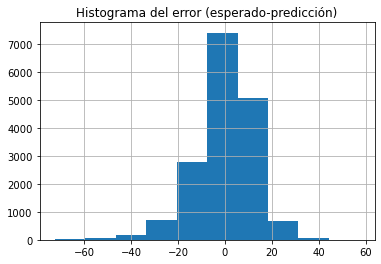

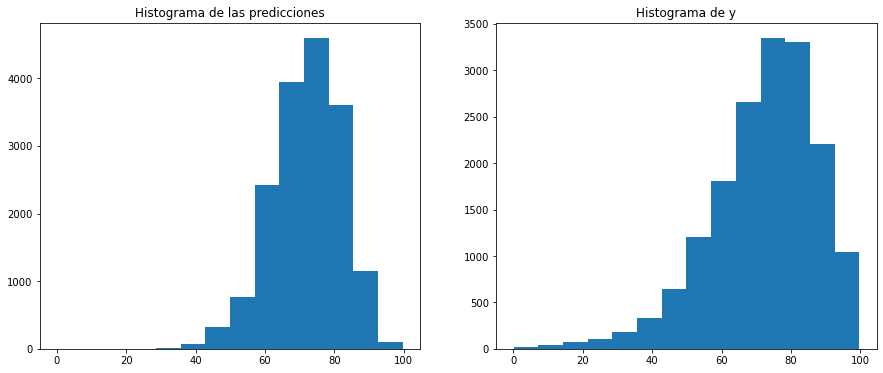




Residuos


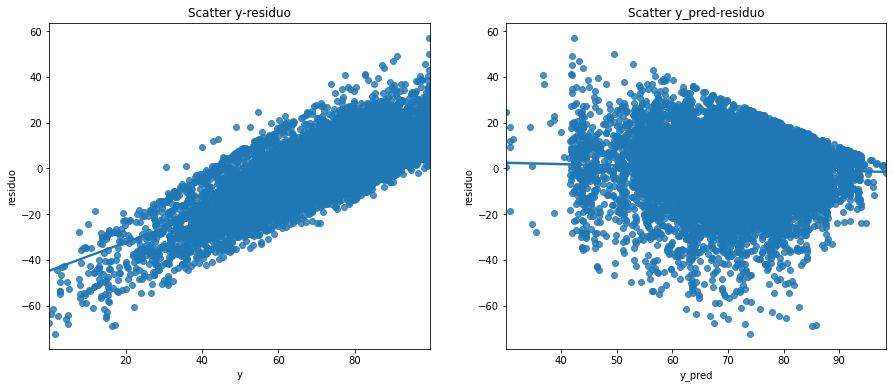








SQR - Predicción SQR


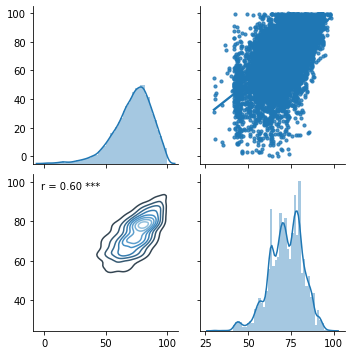

In [20]:
result = cross_val_reg(rfr_test, X_train, y_train, cv=10, plots=(err_hist, pred_hist, plot_residuo, plot_corr_matrix))